(5000, 4)


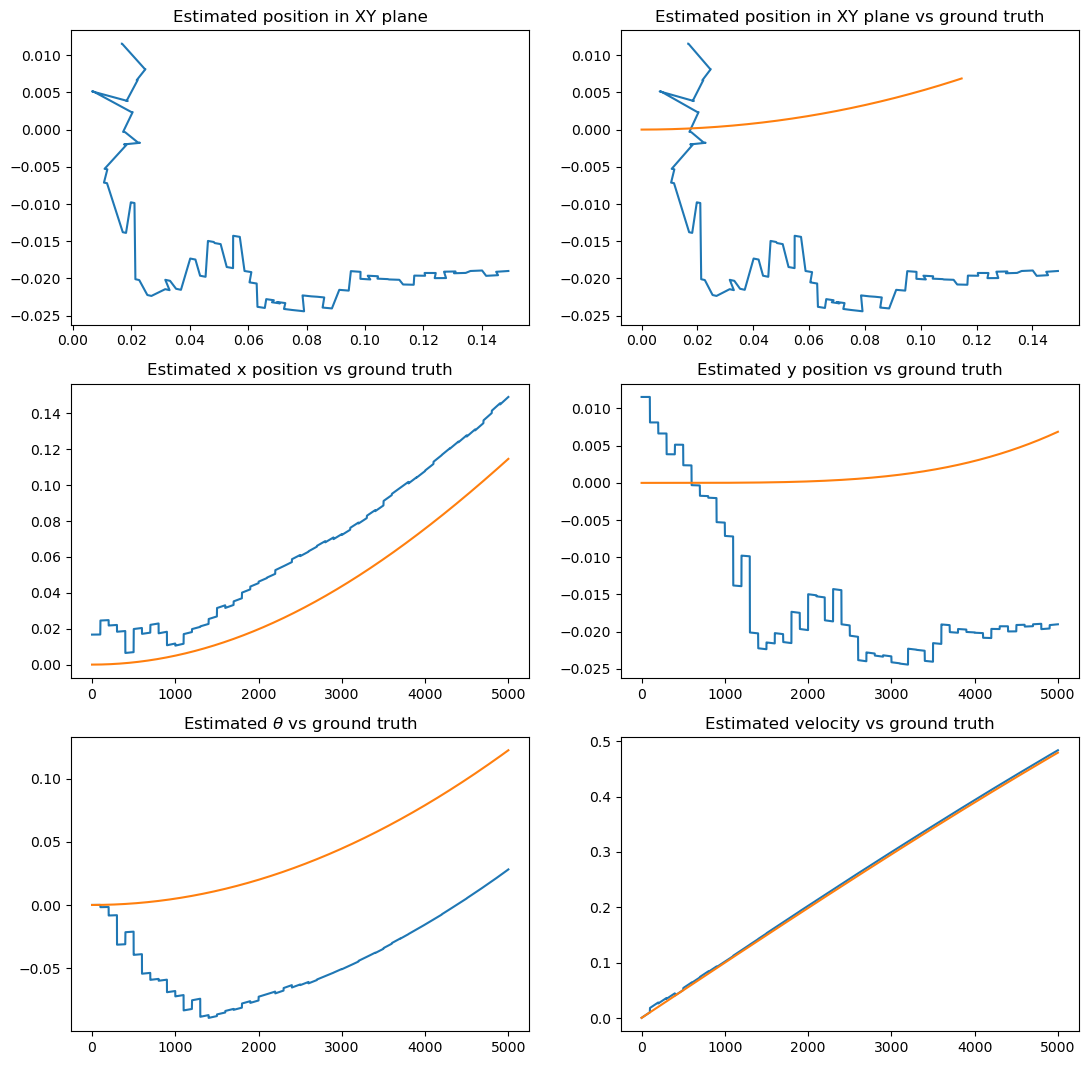

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from vehicle import Vehicle

NUMSTATES = 4
num_iterations = 5000
timesteps = np.arange(0,num_iterations)

trajectory = np.empty((0,NUMSTATES), float)
ground_truth = np.empty((0,NUMSTATES), float)
covariances = []

#Initialize model
x0 = np.array([0,0,0,0])
P0 = np.eye(NUMSTATES)
gt = x0

measurement_stds=np.array([0.01,0.01,0.001,0.002])
vehicle = Vehicle(x=x0, measurement_stds=measurement_stds)

u = np.vstack((num_iterations*[2], num_iterations*[0.5]))
#u = np.vstack(([0.01*np.cos(timesteps/10000)],[0.01*np.sin(timesteps/10000)]))

x_prev = x0
P_prev = P0

Q = np.diag(np.zeros((NUMSTATES)))
R_full = np.diag(measurement_stds)
R_input = np.diag(measurement_stds[2:])

k = 0
while k <= num_iterations - 1:
    
    #Prediction step
    P_pred = vehicle.F(x_prev) @ P_prev @ vehicle.F(x_prev).T + Q
    x_pred = vehicle.f(x_prev, u[:,k])
    #Update step
    if k % 100 == 0:
        R = R_full
        y, G = vehicle.full_observation(x_prev, u[:,k])
        g, _ = vehicle.full_observation(x_pred, u[:,k], enable_noise=False)
    else: 
        R = R_input
        y, G = vehicle.rate_and_accel_observation(x_prev, u[:,k])
        g, _ = vehicle.full_observation(x_pred, u[:,k], enable_noise=False)
    

    #Kalman gain and covariance
    K = P_pred @ G.T @ np.linalg.inv(G @ P_pred @ G.T + R)
    P = (np.eye(x_pred.size) - K @ G) @ P_pred
    
    x = x_pred + K @ (y - g[-y.size:])

    x_prev = x
    P_prev = P
    trajectory = np.vstack((trajectory, x))

    #Store ground truth
    gt = vehicle.f(gt, u[:,k])
    ground_truth = np.vstack((ground_truth, gt))
    
    #Count iterations
    k+=1

print(ground_truth.shape)
plt.rcParams['figure.figsize'] = [13, 13]
fig, axs = plt.subplots(3, 2)
axs[0,0].plot(trajectory[:,0], trajectory[:,1])
axs[0,0].set_title('Estimated position in XY plane')
axs[0,1].plot(trajectory[:,0], trajectory[:,1], ground_truth[:,0], ground_truth[:,1])
axs[0,1].set_title('Estimated position in XY plane vs ground truth')
states = ["x position","y position",r"$\theta$","velocity"]
for i in range(NUMSTATES):
    axs[1+i//2, i%2].plot(timesteps, trajectory[:,i], ground_truth[:,i])
    axs[1+i//2, i%2].set_title(f'Estimated {states[i]} vs ground truth')


